In [85]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict
from functools import reduce
from path import Path
from pprint import pprint

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16,6

Note: During one of his talks Marcos' mentioned that this is one of his favorite applications of ML in Finance

# 3.1a

Form dollar bars for E-mini S&P 500 futures:

Apply a symmetric CUSUM filter where the threshold is the standard deviation of daily returns.

In [86]:
from sampling import dollar_bars
from filters import cusum
from multiprocess import mpPandasObj
from load_data import load_contracts
import yfinance as yf

aapl_stock = yf.download("AAPL",start='2010-01-01') #load_contracts('@ES')

[*********************100%***********************]  1 of 1 completed


In [87]:
aapl_stock.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03
mean,67.595929,68.251186,66.870690,67.539687,2.299200e+08
std,65.674801,66.285181,64.975460,65.595878,2.180726e+08
min,5.785830,5.904831,5.731601,5.795472,2.323470e+07
25%,17.480883,17.664842,17.335043,17.484472,8.492275e+07
50%,35.362555,35.768027,35.001778,35.393598,1.403920e+08
75%,127.049152,128.139892,124.965067,126.478002,3.081386e+08
max,259.019989,260.100006,257.630005,258.190002,1.880998e+09


In [120]:
def getDailyVol(close, span0=100):
    # daily vol, reindexed to cloes
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1 # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

aapl_stock['Instrument'] = 'AAPL' # type: ignore
aapl_dbars = dollar_bars(aapl_stock, 10000000000)

daily_vol = getDailyVol(aapl_dbars['Close'])

In [117]:
aapl_stock

Price,Close,High,Low,Open,Volume,Instrument
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2010-01-04,6.447412,6.462174,6.398306,6.429939,493729600,AAPL
2010-01-05,6.458557,6.495010,6.424514,6.465185,601904800,AAPL
2010-01-06,6.355829,6.484169,6.349201,6.458561,552160000,AAPL
2010-01-07,6.344077,6.386858,6.297983,6.379326,477131200,AAPL
2010-01-08,6.386255,6.386858,6.298286,6.335642,447610800,AAPL
...,...,...,...,...,...,...
2024-12-24,258.200012,258.209991,255.289993,255.490005,23234700,AAPL
2024-12-26,259.019989,260.100006,257.630005,258.190002,27237100,AAPL


In [118]:
aapl_dbars

,Volume,Dollar Volume,Open,Close,Instrument,Time,Num Ticks
2010-01-04,493729600,3.183278e+09,6.429939,6.447412,AAPL,2010-01-04,1
2010-01-05,1631196000,1.042383e+10,6.465185,6.344077,AAPL,2010-01-05,3
2010-01-08,1504300000,9.504511e+09,6.335642,6.257915,AAPL,2010-01-08,3
2010-01-13,1632853600,1.026201e+10,6.262434,6.203988,AAPL,2010-01-13,3
2010-01-19,1342160400,8.634064e+09,6.276290,6.378723,AAPL,2010-01-19,2
...,...,...,...,...,...,...,...
2024-12-23,64093500,1.642923e+10,254.770004,258.200012,AAPL,2024-12-23,2
2024-12-26,27237100,7.054953e+09,258.190002,259.019989,AAPL,2024-12-26,1
2024-12-27,42355300,1.082559e+10,257.829987,255.589996,AAPL,2024-12-27,1
2024-12-30,35557500,8.967601e+09,252.229996,252.199997,AAPL,2024-12-30,1


<Axes: xlabel='Date'>

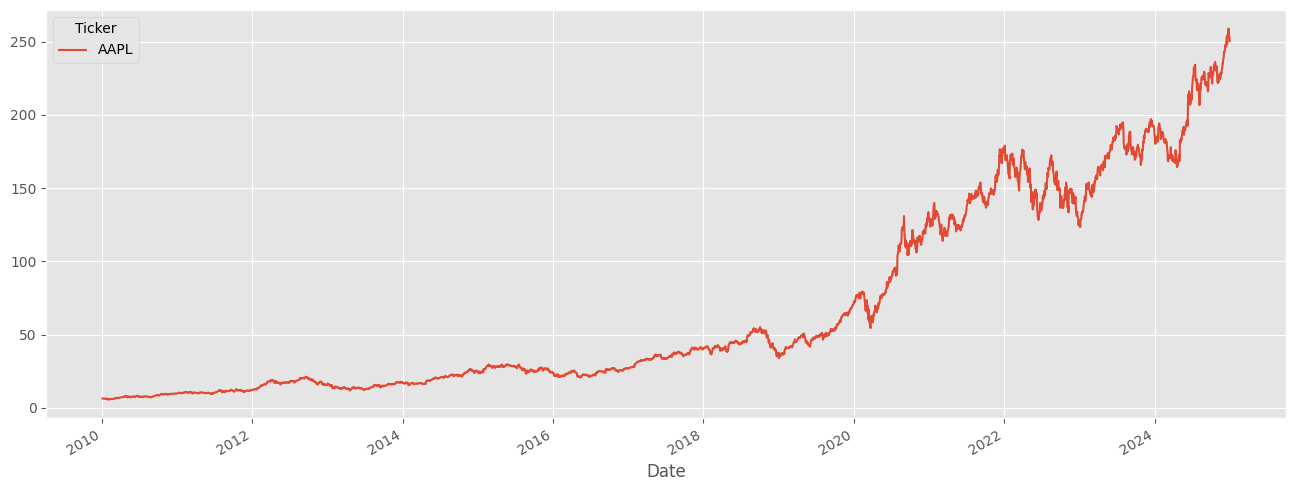

In [89]:
aapl_stock.Close.plot()

<Axes: >

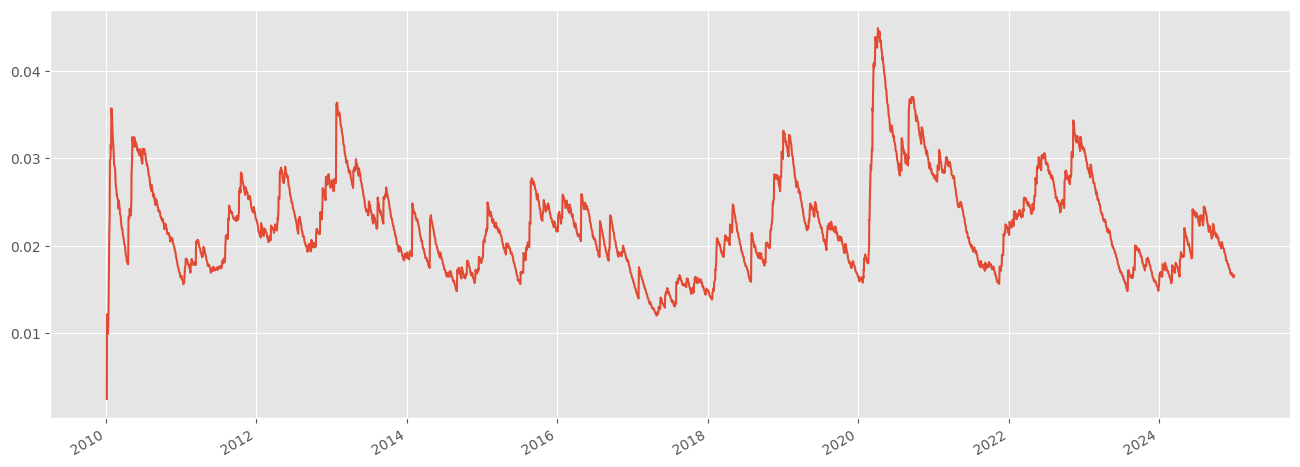

In [90]:
daily_vol.plot()

In [91]:
daily_vol

2010-01-06         NaN
2010-01-07    0.002489
2010-01-08    0.012178
2010-01-11    0.009893
2010-01-12    0.009926
                ...   
2024-12-24    0.016603
2024-12-26    0.016439
2024-12-27    0.016398
2024-12-30    0.016413
2024-12-31    0.016588
Name: Close, Length: 3772, dtype: float64

In [92]:
daily_vol_mean = daily_vol.mean()
sampled_aapl_dbars = cusum(aapl_dbars['Close'], daily_vol_mean)

In [93]:
daily_vol_mean

np.float64(0.0223650633225116)

In [94]:
aapl_dbars['Close'].diff()

2010-01-04         NaN
2010-01-05    0.011145
2010-01-06   -0.102728
2010-01-07   -0.011752
2010-01-08    0.042178
                ...   
2024-12-24    2.930008
2024-12-26    0.819977
2024-12-27   -3.429993
2024-12-30   -3.389999
2024-12-31   -1.779999
Name: Close, Length: 3774, dtype: float64

In [95]:
aapl_dbars.Time

2010-01-04   2010-01-04
2010-01-05   2010-01-05
2010-01-06   2010-01-06
2010-01-07   2010-01-07
2010-01-08   2010-01-08
                ...    
2024-12-24   2024-12-24
2024-12-26   2024-12-26
2024-12-27   2024-12-27
2024-12-30   2024-12-30
2024-12-31   2024-12-31
Name: Time, Length: 3774, dtype: datetime64[ns]

In [96]:
sampled_aapl_dbars

DatetimeIndex(['2010-01-06', '2010-01-11', '2010-01-12', '2010-01-14',
               '2010-01-15', '2010-01-20', '2010-01-21', '2010-01-22',
               '2010-01-28', '2010-01-29',
               ...
               '2024-11-11', '2024-11-15', '2024-11-21', '2024-11-27',
               '2024-12-06', '2024-12-11', '2024-12-18', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=1670, freq=None)

# 3.1b

Form dollar bars for E-mini S&P 500 futures:

Use Snippet 3.4 on a pandas series t1, where numDays=1

In [97]:
def getVerticalBarriers(close, tEvents, numDays):
    t1 = close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]]) # NaNs at the end
    return t1

close = aapl_dbars['Close']
tEvents = sampled_aapl_dbars
numDays = 1

t1 = getVerticalBarriers(close, tEvents, numDays)

In [119]:
tEvents

DatetimeIndex(['2010-01-06', '2010-01-11', '2010-01-12', '2010-01-14',
               '2010-01-15', '2010-01-20', '2010-01-21', '2010-01-22',
               '2010-01-28', '2010-01-29',
               ...
               '2024-11-11', '2024-11-15', '2024-11-21', '2024-11-27',
               '2024-12-06', '2024-12-11', '2024-12-18', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=1670, freq=None)

In [98]:
t1

2010-01-06   2010-01-07
2010-01-11   2010-01-12
2010-01-12   2010-01-13
2010-01-14   2010-01-15
2010-01-15   2010-01-19
                ...    
2024-12-06   2024-12-09
2024-12-11   2024-12-12
2024-12-18   2024-12-19
2024-12-27   2024-12-30
2024-12-30   2024-12-31
Length: 1669, dtype: datetime64[ns]

# 3.1c

Form dollar bars for E-mini S&P 500 futures:

On those sampled features, apply the triple-barrier method, where ptS1 = [1,1] and t1 is the series you created in point 1.b

In [99]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=1, t1=False, side=None):
    # 1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]
    # 2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    # 3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.0, index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt']) # type: ignore
    df0 = mpPandasObj(func=applyPtSlOnT1, pdObj=('molecule', events.index), numThreads=numThreads, close=close, events=events, ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # type: ignore # pd.min ignores NaN
    if side is None:
        events = events.drop('side', axis=1)

    # store for later
    events['pt'] = ptSl[0]
    events['sl'] = ptSl[1]

    return events
    
def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)

    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs

    if ptSl[1] > 0:
        sl = - ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index) # 'mo NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side'] # path returns
        out.loc[loc, 'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0>pt[loc]].index.min() # earliest profit take
    return out

In [100]:
events = getEvents(aapl_dbars['Close'], tEvents=tEvents, ptSl=[1,1], t1=t1, numThreads=1, trgt=daily_vol, minRet=0.01)

In [101]:
events.head()

,t1,trgt,pt,sl
2010-01-14,2010-01-15,0.011626,1,1
2010-01-15,2010-01-19,0.012222,1,1
2010-01-20,2010-01-21,0.022422,1,1
2010-01-21,2010-01-22,0.023669,1,1
2010-01-22,2010-01-25,0.029649,1,1


# 3.1d

Form dollar bars for E-mini S&P 500 futures:

Apply `getBins` to generate the labels.


In [102]:
def getBins(events, close):
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    out['bin'] = np.sign(out['ret'])
    return out

In [103]:
bins = getBins(events, close)

In [104]:
bins.head()

,ret,bin
2010-01-14,-0.016712,-1.0
2010-01-15,0.044238,1.0
2010-01-20,-0.017286,-1.0
2010-01-21,-0.049599,-1.0
2010-01-22,0.026903,1.0


In [105]:
bins['bin'].value_counts()

bin
 1.0    880
-1.0    782
 0.0      4
Name: count, dtype: int64

In [106]:
bins['bin'].value_counts(normalize=True)

bin
 1.0    0.528211
-1.0    0.469388
 0.0    0.002401
Name: proportion, dtype: float64

# 3.2

From exercise 1, use Snippet 3.8 to drop rare labels.

In [107]:
def dropLabels(events, mitPct=0.05):
    # apply weights, drop labels with insufficient examples
    while True:
        
        df0 = events['bin'].value_counts(normalize=True)
        
        if df0.min() > mitPct or df0.shape[0] < 3:
            break
        print("Dropped label", df0.argmin(), df0.min())
        events = events[events['bin'] != df0.index[df0.argmin()]]
    return events


In [108]:
bins = dropLabels(bins)

Dropped label 2 0.0024009603841536613


In [109]:
bins['bin'].value_counts(normalize=True)

bin
 1.0    0.529483
-1.0    0.470517
Name: proportion, dtype: float64

# 3.3

Adjust the `getBins` function (Snippet 3.5) to return a 0 whenever the vertical barrier is the first one touched.

In [110]:
def barrier_touched(out_df, events):
    # We'll graciously use the barrier_touched method from
    # https://github.com/hudson-and-thames/mlfinlab/blob/master/mlfinlab/labeling/labeling.py#L164
    store = []
    for date_time, values in out_df.iterrows():
        ret = values['ret']
        target = values['trgt']

        pt_level_reached = ret > target * events.loc[date_time, 'pt']
        sl_level_reached = ret < -target * events.loc[date_time, 'sl']

        if ret > 0.0 and pt_level_reached:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and sl_level_reached:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    # Save to 'bin' column and return
    out_df['bin'] = store
    return out_df


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1, 1) <- label by price action
    Case 2: ('side' in events): bin in (0, 1) <- label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)

    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling

    out['trgt'] = events_['trgt']
    out = barrier_touched(out, events)

    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0
        
    if 'side' in events_:
        out['side'] = events['side']
    return out


In [111]:
bins = getBins(events, close)

In [112]:
bins

,ret,trgt,bin
2010-01-14,-0.016712,0.011626,-1
2010-01-15,0.044238,0.012222,1
2010-01-20,-0.017286,0.022422,0
2010-01-21,-0.049599,0.023669,-1
2010-01-22,0.026903,0.029649,0
...,...,...,...
2024-12-06,0.016101,0.017416,0
2024-12-11,0.005964,0.017163,0
2024-12-18,0.007015,0.016708,0
2024-12-27,-0.013263,0.016398,0


In [113]:
bins['bin'].value_counts()

bin
 0    1362
-1     162
 1     142
Name: count, dtype: int64

# 3.4a

Develop a trend-following strategy based on a popular technical analysis statistic (e.g. MA Crossover). For each observation, the model suggests a side, but not a size of the bet.

Derive meta-labels for `ptSl = [1,2]` and `t1` where `numDays=1`. Use as `trgt` the daily standard deviation as computed by Snippet 3.1.

In [109]:
df = aapl_dbars.copy().truncate(before='2017')
tEvents = cusum(df['Close'], getDailyVol(df['Close']).mean())
t1 = getVerticalBarriers(df['Close'], tEvents, numDays=1)
events = getEvents(close, tEvents=tEvents, ptSl=[1,2], t1=t1, trgt=daily_vol, minRet=0.01)


In [110]:
slow_ma = close.rolling(100).mean()
fast_ma = close.rolling(10).mean()

long_signals = (fast_ma >= slow_ma)
short_signals = (fast_ma < slow_ma)
close = df['Close']

events.loc[long_signals, 'side'] = 1
events.loc[short_signals, 'side'] = -1
events['side'] = events['side'].shift()


In [111]:
bins = getBins(events, df['Close'])

In [112]:
events.head()

,t1,trgt,pt,sl,side
2018-02-05 10:28:00,2018-02-05 13:02:00,0.010232,1,2,NaN
2018-02-05 10:34:00,2018-02-05 13:09:00,0.010271,1,2,-1.0
2018-02-05 10:54:00,2018-02-05 13:02:00,0.010475,1,2,-1.0
2018-02-05 11:01:00,2018-02-05 13:05:00,0.010512,1,2,-1.0
2018-02-05 11:10:00,2018-02-05 13:14:00,0.010515,1,2,-1.0


In [113]:
bins['bin'].value_counts()

0    1302
1     445
Name: bin, dtype: int64

# 3.4b

Develop a trend-following strategy based on a popular technical analysis statistic (e.g. MA Crossover). For each observation, the model suggests a side, but not a size of the bet.

Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {-1, 1}.

In [114]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# We'll use the features described in 3.5b (vol, serial corr., ma crosses)
df['log_ret'] = np.log(close).diff()
df['vol5'] = df['log_ret'].rolling(5).std()
df['vol10'] = df['log_ret'].rolling(10).std()
df['vol15'] = df['log_ret'].rolling(15).std()

df['serialcorr20-1'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=1))
df['serialcorr20-2'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=2))
df['serialcorr20-3'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=3))

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1
df['side'] = df['side'].shift()


/Users/doda/anaconda3/envs/zippy/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':
/Users/doda/anaconda3/envs/zippy/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # Remove the CWD from sys.path while we load stuff.
/Users/doda/anaconda3/envs/zippy/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will chang

In [115]:
train_features = df.loc[events.index][['side', 'vol5', 'vol10', 'vol15', 'serialcorr20-1', 'serialcorr20-2', 'serialcorr20-3']]
train_labels = bins['bin']

In [116]:
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# 3.5a

Develop a mean-reverting strategy based on Bollinger Bands. For each observation, the model suggests a side, but not a size of the bet.

Derive meta-labels for `ptSl = [0,2]` and `t1` where `numDays=1`. Use as `trgt` the daily standard deviation.

In [117]:
events = getEvents(close, tEvents=tEvents, ptSl=[0,2], t1=t1, trgt=daily_vol, minRet=0.01)
events.head()

,t1,trgt,pt,sl
2018-02-05 10:28:00,2018-02-06 10:30:00,0.010232,0,2
2018-02-05 10:34:00,2018-02-06 10:36:00,0.010271,0,2
2018-02-05 10:54:00,2018-02-06 10:55:00,0.010475,0,2
2018-02-05 11:01:00,2018-02-06 11:05:00,0.010512,0,2
2018-02-05 11:10:00,2018-02-06 11:11:00,0.010515,0,2


# 3.5b

Develop a mean-reverting strategy based on Bollinger Bands. For each observation, the model suggests a side, but not a size of the bet.

Train a random forest to decide whether to trade or not. Use as features: volatility, serial correlation, and the crossing moving averages from exercise 2.


In [118]:
def bbands(close, window, stdev=2):
    ma = close.rolling(window).mean()
    std = close.rolling(window).std()
    return (ma + stdev * std, ma - stdev * std)
    
df['bb_upper_band'], df['bb_lower_band'] = bbands(close, 100, 2)
short_signals = close > df['bb_upper_band']
long_signals = close < df['bb_lower_band']

df['side'] = np.nan
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1
df['side'] = df['side'].ffill() # long until we're short
df = df.shift() # No look-ahead

In [119]:
df.side.value_counts()

-1.0    14021
 1.0    11564
Name: side, dtype: int64

In [131]:
train_features = df.loc[events.index][['side', 'vol5', 'vol10', 'vol15', 'serialcorr20-1', 'serialcorr20-2', 'serialcorr20-3']]
train_labels = bins['bin']

rf = RandomForestClassifier(n_estimators=100, random_state=10, max_depth=5)
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

# 3.5c

Develop a mean-reverting strategy based on Bollinger Bands. For each observation, the model suggests a side, but not a size of the bet.

What is the accuracy of predictions from the primary model (i.e. if the secondary model does not filter the bets)? What are the precision, recall, and F-1 scores?


In [132]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

primary_forecast = pd.DataFrame(bins['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1302
           1       0.25      1.00      0.41       445

   micro avg       0.25      0.25      0.25      1747
   macro avg       0.13      0.50      0.20      1747
weighted avg       0.06      0.25      0.10      1747

Confusion Matrix
[[   0 1302]
 [   0  445]]

Accuracy
0.25472238122495705


/Users/doda/anaconda3/envs/zippy/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 3.5d

Develop a mean-reverting strategy based on Bollinger Bands. For each observation, the model suggests a side, but not a size of the bet.

What is the accuracy of prediction from the secondary model? What are the precision, recall, and F1-scores?


              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1302
           1       0.88      0.29      0.44       445

   micro avg       0.81      0.81      0.81      1747
   macro avg       0.84      0.64      0.66      1747
weighted avg       0.82      0.81      0.77      1747

Confusion Matrix
[[1284   18]
 [ 315  130]]

Accuracy
0.8093875214653692


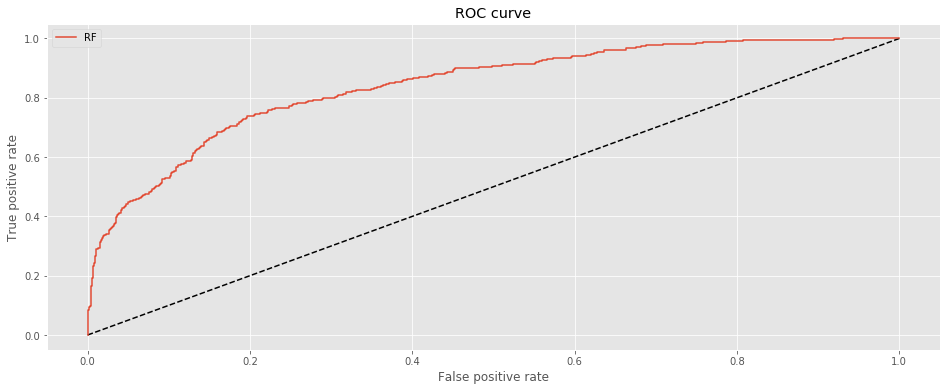

In [133]:
y_train = bins['bin']
X_train = train_features
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
